# 端到端模型执行

In [1]:
import numpy as np
import tvm
from tvm import relax
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T

## 准备数据集

In [2]:
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

100%|██████████| 26421880/26421880 [00:05<00:00, 5244432.43it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 179199.39it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3342823.61it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9259123.92it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



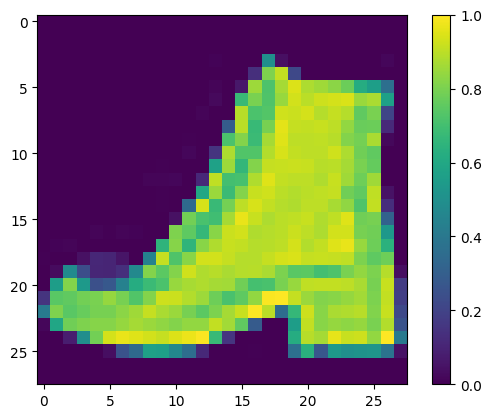

Class: Ankle boot


In [3]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()
print("Class:", class_names[label[0]])

## 端到端模型整合

下载模型参数：
```bash
!wget https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl
```

NumPy 实现：

In [6]:
def numpy_mlp(data, w0, b0, w1, b1):
    lv0 = data @ w0.T + b0
    lv1 = np.maximum(lv0, 0)
    lv2 = lv1 @ w1.T + b1
    return lv2

In [7]:
import pickle as pkl

with open("fasionmnist_mlp_params.pkl", "rb") as fp:
    mlp_params = pkl.load(fp)
res = numpy_mlp(img.reshape(1, 784),
                mlp_params["w0"],
                mlp_params["b0"],
                mlp_params["w1"],
                mlp_params["b1"])
print(res)
pred_kind = res.argmax(axis=1)
print(pred_kind)
print("NumPy-MLP Prediction:", class_names[pred_kind[0]])

[[-48.875954 -59.9502   -25.205477 -29.042246 -32.529125   4.8162
  -35.510296 -17.531176 -13.222308  27.285019]]
[9]
NumPy-MLP Prediction: Ankle boot


## 使用 TVMScript 实现算子 & MLP 模型

`main` 函数里是模型，其他函数是算子。另外，用到 2 个新 API:

1. `Relax.call_tir`: 先申请 output 内存，然后传给 TIR 函数。
    - 调用者使用更简单。
    - 以 call_tir 做为 node 画 dataflow 图，更清晰。不再受 output 内存申请 node 的干扰。
2. `with Relax.dataflow()`: 显示声明 dataflow。允许把原图拆成多个 dataflow，dataflow 之间可以插入非 pure function。

In [8]:
# implement using TVMScript
@tvm.script.ir_module
class MyModule: 
    @T.prim_func
    def relu0(X: T.Buffer((1, 128), "float32"), 
              Y: T.Buffer((1, 128), "float32")):
        # function attr dict
        T.func_attr({"global_symbol": "relu0", "tir.noalias": True})
        for i, j in T.grid(1, 128):
            with T.block("Y"):
                vi, vj = T.axis.remap("SS", [i, j])
                Y[vi, vj] = T.max(X[vi, vj], T.float32(0))

    @T.prim_func
    def linear0(X: T.Buffer((1, 784), "float32"), 
                W: T.Buffer((128, 784), "float32"), 
                B: T.Buffer((128,), "float32"), 
                Z: T.Buffer((1, 128), "float32")):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), "float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
    
        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] =  Y[vi, vj] + B[vj]

    @T.prim_func
    def linear1(X: T.Buffer((1, 128), "float32"), 
                W: T.Buffer((10, 128), "float32"), 
                B: T.Buffer((10,), "float32"), 
                Z: T.Buffer((1, 10), "float32")):
        T.func_attr({"global_symbol": "linear1", "tir.noalias": True})
        Y = T.alloc_buffer((1, 10), "float32")
        for i, j, k in T.grid(1, 10, 128):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
    
        for i, j in T.grid(1, 10):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] = Y[vi, vj] + B[vj]

    @R.function
    def main(x: R.Tensor((1, 784), "float32"), 
             w0: R.Tensor((128, 784), "float32"), 
             b0: R.Tensor((128,), "float32"), 
             w1: R.Tensor((10, 128), "float32"), 
             b1: R.Tensor((10,), "float32")):
        with R.dataflow():
            cls = MyModule
            lv0 = R.call_tir(cls.linear0, (x, w0, b0), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            lv1 = R.call_tir(cls.relu0, (lv0,), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            out = R.call_tir(cls.linear1, (lv1, w1, b1), out_sinfo=R.Tensor((1, 10), dtype="float32"))
            R.output(out)
        return out

构建并运行模型：

In [10]:
ex = relax.build(MyModule, target="llvm")

vm = relax.VirtualMachine(ex, tvm.cpu())

data_nd = tvm.nd.array(img.reshape(1, 784))
nd_params = {k: tvm.nd.array(v) for k, v in mlp_params.items()}

nd_res = vm["main"](data_nd, nd_params["w0"], nd_params["b0"], nd_params["w1"], nd_params["b1"])

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModule Prediction:", class_names[pred_kind[0]])

MyModule Prediction: Ankle boot


## 3. 注册 pytorch 算子并使用

注意，用的 API 有变化，新增 `Relax.call_dps_packed`：

1. 前面调用 TVMScript (TIR) 实现的算子，用的 API 是 Relax.call_tir
2. 调用外部注册的算子，传参是 string (func name)，用的 API 是 `Relax.call_dps_packed`

###  注册 pytorch 算子

1. 用 `torch.from_dlpack` 从 TVM NDArray 转 torch NDArray. 二者共享内存，是 zero copy 的。
2. [DLPack](https://dmlc.github.io/dlpack/latest/python_spec.html) 是不同 framework 之间 zero copy 交换 Tensor/NDArray 的标准。

In [12]:
@tvm.register_func("env.linear", override=True)
def torch_linear(x: tvm.nd.NDArray, 
                 w: tvm.nd.NDArray, 
                 b: tvm.nd.NDArray, 
                 out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    w_torch = torch.from_dlpack(w)
    b_torch = torch.from_dlpack(b)
    out_torch = torch.from_dlpack(out)
    torch.mm(x_torch, w_torch.T, out=out_torch)
    torch.add(out_torch, b_torch, out=out_torch)

@tvm.register_func("env.relu", override=True)
def lnumpy_relu(x: tvm.nd.NDArray, 
                out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    out_torch = torch.from_dlpack(out)
    torch.maximum(x_torch, torch.Tensor([0.0]), out=out_torch)

### 混合使用算子

In [13]:
@tvm.script.ir_module
class MyModuleMixture: 
    @T.prim_func
    def linear0(X: T.Buffer((1, 784), "float32"), 
                W: T.Buffer((128, 784), "float32"), 
                B: T.Buffer((128,), "float32"), 
                Z: T.Buffer((1, 128), "float32")):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), "float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
    
        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] =  Y[vi, vj] + B[vj]

    @R.function
    def main(x: R.Tensor((1, 784), "float32"), 
             w0: R.Tensor((128, 784), "float32"), 
             b0: R.Tensor((128,), "float32"), 
             w1: R.Tensor((10, 128), "float32"), 
             b1: R.Tensor((10,), "float32")):
        with R.dataflow():
            cls = MyModuleMixture
            lv0 = R.call_tir(cls.linear0, (x, w0, b0), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            lv1 = R.call_dps_packed("env.relu", (lv0,), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            out = R.call_dps_packed("env.linear", (lv1, w1, b1), out_sinfo=R.Tensor((1, 10), dtype="float32"))
            R.output(out)
        return out

构建并运行模型：

In [15]:
ex = relax.build(MyModuleMixture, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd, 
                    nd_params["w0"],
                    nd_params["b0"],
                    nd_params["w1"],
                    nd_params["b1"])

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleMixture Prediction:", class_names[pred_kind[0]])

MyModuleMixture Prediction: Ankle boot


## 将参数绑定到 IRModule

把模型权重 bind 到 IRModule 上，这样，后续运行模型时，就不用再传权重了。只需要传 input data。

In [16]:
# bind param, build and run

# nd_params is the weight and bias of the model
MyModuleWithParams = relax.transform.BindParams("main", nd_params)(MyModuleMixture)

ex = relax.build(MyModuleWithParams, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

# only input data is needed as the weight params are already binded
nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithParams Prediction:", class_names[pred_kind[0]])

MyModuleWithParams Prediction: Ankle boot


````{note}
重点：`metadata["relax.expr.Constant"][0]` 就是存储了权重 constant 的 dict。
````

In [17]:
MyModuleWithParams.show()

/media/pc/data/lxw/ai/tvm/xinetzone/__pypackages__/3.10/lib/tvm/script/highlight.py:117: UserWarning: No module named 'black'
To print formatted TVM script, please install the formatter 'Black':
/media/pc/data/tmp/cache/conda/envs/tvmz/bin/python -m pip install "black==22.3.0" --upgrade --user
  warnings.warn(
